<a href="https://colab.research.google.com/github/ChangCorp/finalproject/blob/main/ChangCorp_Stage_2_Version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HOMEWORK DATA PRE-PROCESSING

In [ ]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder   
import pickle  
from pathlib import Path  

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 
matplotlib.style.use('ggplot') 


## 1. Data Cleansing

In [ ]:
df_train_raw = pd.read_csv('https://raw.githubusercontent.com/ChangCorp/finalproject/main/train_delimited_comma.csv')
df_test_raw = pd.read_csv('https://raw.githubusercontent.com/ChangCorp/finalproject/main/test_delimited_comma.csv')

In [ ]:
# menyalin dataset agar tidak mengubah dataset raw
df_train = df_train_raw.copy()
df_test = df_test_raw.copy()

In [ ]:
df_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
df_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


### A. Handle Missing Value

In [ ]:
# mengetahui missing value
df_train.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

* Tidak ditemukan missing value namun terdapat nilai *unknown* pada kolom `job`, `education`, `contact`, dan `poutcome`. <br>
* Kolom `job`, `education`, `contact` memikliki unknown yang relatif tidak banyak, akan diisi dengan nilai mode. <br>
* Kolom `poutcome` memiliki *unknown* sekitar 37k records, akan di-feature encoding menjadi poutcome_success 0 1, <br>

##### Handling *Unknown* value `job`

In [ ]:
df_train1=df_train.groupby(['education','job']).agg({'job':['count']})

df_train1=df_train1.reset_index() #diperlukan supaya bisa ganti nama kolom
df_train1.columns=['education','job','count']
df_train1.head()

,education,job,count
0,primary,admin.,209
1,primary,blue-collar,3758
2,primary,entrepreneur,183
3,primary,housemaid,627
4,primary,management,294


In [ ]:
# Mengambil mode job untuk tiap education
df_train1["rank"]=df_train1.groupby('education')['count'].rank(method="dense", ascending=False)
df_train1[df_train1['rank']==1].sort_values(['education'],ascending=[True])

,education,job,count,rank
1,primary,blue-collar,3758,1.0
13,secondary,blue-collar,5371,1.0
28,tertiary,management,7801,1.0
37,unknown,blue-collar,454,1.0


In [ ]:
# Nilai unknown pada `job` berubah menyesuaikan data `education`

df_train.loc[(df_train.job == "unknown") & (df_train.education == "primary"),"job"] = "blue-collar"
df_train.loc[(df_train.job == "unknown") & (df_train.education == "secondary"),"job"] = "blue-collar"
df_train.loc[(df_train.job == "unknown") & (df_train.education == "tertiary"),"job"] = "management"
df_train.loc[(df_train.job == "unknown") & (df_train.education == "unknown"),"job"] = "blue-collar"

In [ ]:
# Nilai unknown pada `job` berubah menyesuaikan data `education`
df_train["job"].value_counts()

blue-collar      9981
management       9497
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
Name: job, dtype: int64

##### Handling *Unknown* value  `education`

In [ ]:
# Mengambil mode education untuk tiap job
df_train1["rank2"]=df_train1.groupby('job')['count'].rank(method="dense", ascending=False)
df_train1[df_train1['rank2']==1].sort_values(['job'],ascending=[True])

,education,job,count,rank,rank2
12,secondary,admin.,4219,3.0,1.0
13,secondary,blue-collar,5371,1.0,1.0
26,tertiary,entrepreneur,686,4.0,1.0
3,primary,housemaid,627,3.0,1.0
28,tertiary,management,7801,1.0,1.0
17,secondary,retired,984,6.0,1.0
30,tertiary,self-employed,833,3.0,1.0
19,secondary,services,3457,4.0,1.0
20,secondary,student,508,10.0,1.0
21,secondary,technician,5229,2.0,1.0


In [ ]:
# Nilai unknown pada `education` berubah menyesuaikan data modus pada `job`

df_train.loc[(df_train.education == "unknown") & (df_train.job == "admin."),"education"] = "secondary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "blue-collar"),"education"] = "secondary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "entrepreneur"),"education"] = "tertiary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "housemaid"),"education"] = "primary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "management"),"education"] = "tertiary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "retired"),"education"] = "secondary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "self-employed"),"education"] = "tertiary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "services"),"education"] = "secondary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "student"),"education"] = "secondary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "technician"),"education"] = "secondary"
df_train.loc[(df_train.education == "unknown") & (df_train.job == "unemployed"),"education"] = "secondary"
df_train.loc[(df_train.education == "unknown"),"education"] = "secondary"

In [ ]:
df_train["education"].value_counts()

secondary    24657
tertiary     13658
primary       6896
Name: education, dtype: int64

##### Handling *Unknown* value  `contact`

In [ ]:
df_train["contact"].replace(["unknown"],df_train["contact"].mode(),inplace = True)

In [ ]:
df_train["contact"].value_counts()

cellular     42305
telephone     2906
Name: contact, dtype: int64

##### Insight 
Sudah tidak ada nilai *unknown* pada kolom `education` , `job`, `contact` 

In [ ]:
df_train.shape

(45211, 17)

In [ ]:
df_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


### B. Handle Duplicate Data

In [ ]:
# mengetahui jumlah baris yang duplicated terhadap semua kolom
print('Jumlah baris duplicate: ', df_train.duplicated().sum())

Jumlah baris duplicate:  0


##### Insight

Tidak ada data yang duplikat sehingga tidak dilakukan drop duplicates

### C. Handle Outliers

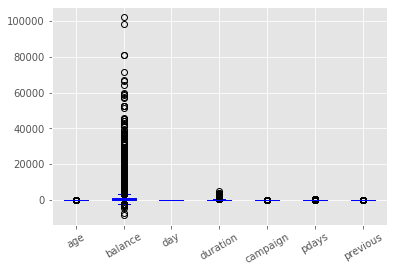

In [ ]:
df_train.boxplot(grid='false', color='blue',fontsize=10, rot=30 )

dapat dilihat pada grafik diatas bahwa kolom age, balance, duration, campaign, pdays, dan previous terdapat outliers

In [ ]:
print(df_train.shape)
print(df_train.shape)

(45211, 17)
(45211, 17)


Jumlah baris sebelum memfilter outlier: 45211
Jumlah baris setelah memfilter outlier: 28069


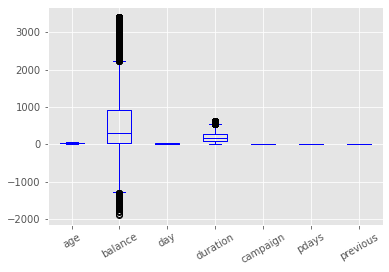

In [ ]:
print(f'Jumlah baris sebelum memfilter outlier: {len(df_train)}')

for col in ['age', 'day', 'balance', 'duration', 'campaign', 'pdays', 'previous']:
  Q1 = df_train[col].quantile(0.25)
  Q3 = df_train[col].quantile(0.75)
  IQR = Q3-Q1
  low_limit = Q1 - 1.5*IQR
  high_limit = Q3 + 1.5*IQR
  df_train = df_train[(df_train[col] >= low_limit) & (df_train[col] <= high_limit)]

print(f'Jumlah baris setelah memfilter outlier: {len(df_train)}')
df_train.boxplot(grid='false', color='blue',fontsize=10, rot=30 )

In [ ]:
df_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,may,92,1,-1,0,unknown,no
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,may,198,1,-1,0,unknown,no


### D. Feature Transformation

Feature Tranformation menggunakan Normalizing/standardizing

In [ ]:
# Age
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df_train['age_norm'] = MinMaxScaler().fit_transform(df_train['age'].values.reshape(len(df_train),1))
df_train['age_std'] = StandardScaler().fit_transform(df_train['age'].values.reshape(len(df_train),1))
print(df_train[['age','age_norm','age_std']].describe())
print('')
# Day
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df_train['day_norm'] = MinMaxScaler().fit_transform(df_train['day'].values.reshape(len(df_train),1))
df_train['day_std'] = StandardScaler().fit_transform(df_train['day'].values.reshape(len(df_train),1))
print(df_train[['day','day_norm','day_std']].describe())
print('')
# Balance
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df_train['balance_norm'] = MinMaxScaler().fit_transform(df_train['balance'].values.reshape(len(df_train),1))
df_train['balance_std'] = StandardScaler().fit_transform(df_train['balance'].values.reshape(len(df_train),1))
print(df_train[['balance','balance_norm','balance_std']].describe())
print('')
# Duration
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df_train['duration_norm'] = MinMaxScaler().fit_transform(df_train['duration'].values.reshape(len(df_train),1))
df_train['duration_std'] = StandardScaler().fit_transform(df_train['duration'].values.reshape(len(df_train),1))
print(df_train[['duration','duration_norm','duration_std']].describe())
print('')
# Campaign
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df_train['campaign_norm'] = MinMaxScaler().fit_transform(df_train['campaign'].values.reshape(len(df_train),1))
df_train['campaign_std'] = StandardScaler().fit_transform(df_train['campaign'].values.reshape(len(df_train),1))
print(df_train[['campaign','campaign_norm','campaign_std']].describe())
print('')
# Pdays
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df_train['pdays_norm'] = MinMaxScaler().fit_transform(df_train['pdays'].values.reshape(len(df_train),1))
df_train['pdays_std'] = StandardScaler().fit_transform(df_train['pdays'].values.reshape(len(df_train),1))
print(df_train[['pdays','pdays_norm','pdays_std']].describe())
print('')
# Previous
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df_train['previous_norm'] = MinMaxScaler().fit_transform(df_train['previous'].values.reshape(len(df_train),1))
df_train['previous_std'] = StandardScaler().fit_transform(df_train['previous'].values.reshape(len(df_train),1))
print(df_train[['previous','previous_norm','previous_std']].describe())
print('')

                age      age_norm       age_std
count  28069.000000  28069.000000  2.806900e+04
mean      40.363461      0.430067  2.835184e-16
std        9.883276      0.190063  1.000018e+00
min       18.000000      0.000000 -2.262798e+00
25%       32.000000      0.269231 -8.462387e-01
50%       39.000000      0.403846 -1.379589e-01
75%       48.000000      0.576923  7.726866e-01
max       70.000000      1.000000  2.998709e+00

                day      day_norm       day_std
count  28069.000000  28069.000000  2.806900e+04
mean      15.770744      0.492358  4.455290e-17
std        8.357648      0.278588  1.000018e+00
min        1.000000      0.000000 -1.767364e+00
25%        8.000000      0.233333 -9.297929e-01
50%       16.000000      0.500000  2.743123e-02
75%       22.000000      0.700000  7.453493e-01
max       31.000000      1.000000  1.822226e+00

            balance  balance_norm   balance_std
count  28069.000000  28069.000000  2.806900e+04
mean     602.524315      0.469510 -2.4

Feature Transformation menggunakan Log Transformation

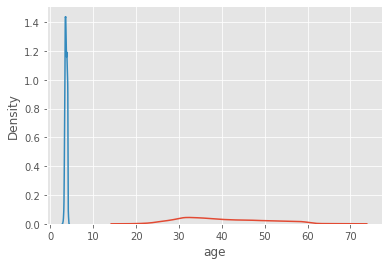

In [ ]:
# Age

# distribusi age (nilai asli)
sns.kdeplot(df_train['age'])
# distribusi age (setelah log transformation)
sns.kdeplot(np.log(df_train['age']))
# transformasi
df_train['log_age'] = np.log(df_train['age'])
# drop kolom age (nilai asli)
#df_train_clean = df_train_clean.drop(columns='age')

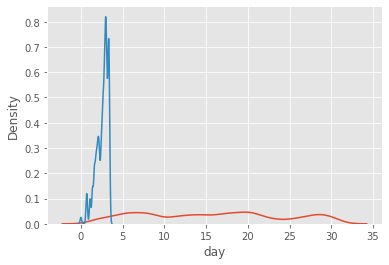

In [ ]:
# Day

# distribusi day (nilai asli)
sns.kdeplot(df_train['day'])
# distribusi day (setelah log transformation)
sns.kdeplot(np.log(df_train['day']))
# transformasi
df_train['log_day'] = np.log(df_train['day'])
# drop kolom age (nilai asli)
#df_train_clean = df_train_clean.drop(columns='day')

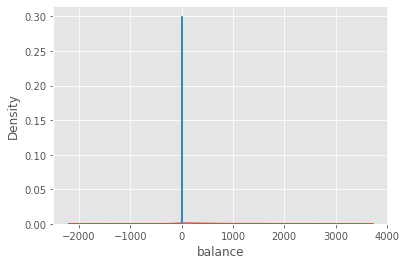

In [ ]:
# Balance

# distribusi balance (nilai asli)
sns.kdeplot(df_train['balance'])
# distribusi day (setelah log transformation)
sns.kdeplot(np.log(df_train['balance']))
# transformasi
df_train['log_balance'] = np.log(df_train['balance'])
# drop kolom age (nilai asli)
#df_train_clean = df_train_clean.drop(columns='balance')

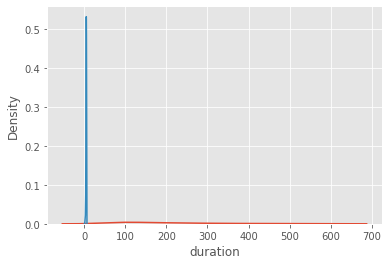

In [ ]:
# Duration

# distribusi duration (nilai asli)
sns.kdeplot(df_train['duration'])
# distribusi duration (setelah log transformation)
sns.kdeplot(np.log(df_train['duration']))
# transformasi
df_train['log_duration'] = np.log(df_train['duration'])
# drop kolom age (nilai asli)
#df_train_clean = df_train_clean.drop(columns='duration')

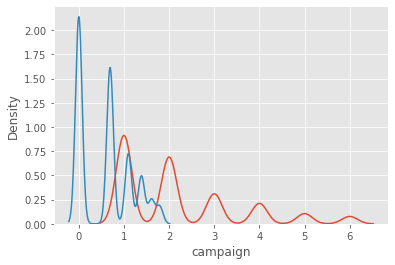

In [ ]:
# Campaign

# distribusi campaign (nilai asli)
sns.kdeplot(df_train['campaign'])
# distribusi campaign (setelah log transformation)
sns.kdeplot(np.log(df_train['campaign']))
# transformasi
df_train['log_campaign'] = np.log(df_train['campaign'])
# drop kolom campaign (nilai asli)
#df = df_train_clean.drop(columns='campaign')

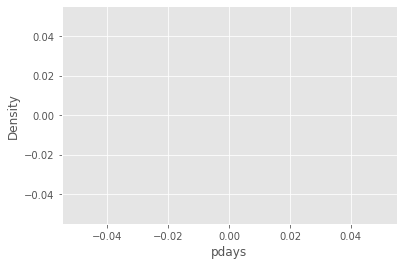

In [ ]:
# Pdays

# distribusi pdays (nilai asli)
sns.kdeplot(df_train['pdays'])
# distribusi pdays (setelah log transformation)
sns.kdeplot(np.log(df_train['pdays']))
# transformasi
df_train['log_pdays'] = np.log(df_train['pdays'])
# drop kolom pdays (nilai asli)
#df_train_clean = df_train_clean.drop(columns='pdays')

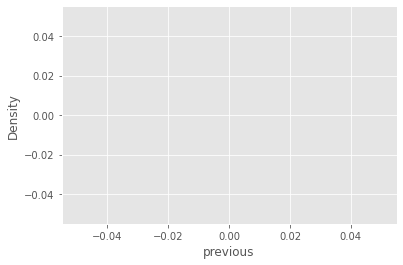

In [ ]:
# Previous

# distribusi previous (nilai asli)
sns.kdeplot(df_train['previous'])
# distribusi previous (setelah log transformation)
sns.kdeplot(np.log(df_train['previous']))
# transformasi
df_train['log_previous'] = np.log(df_train['previous'])
# drop kolom previous (nilai asli)
#df_train_clean = df_train_clean.drop(columns='previous')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28069 entries, 0 to 45209
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            28069 non-null  int64  
 1   job            28069 non-null  object 
 2   marital        28069 non-null  object 
 3   education      28069 non-null  object 
 4   default        28069 non-null  object 
 5   balance        28069 non-null  int64  
 6   housing        28069 non-null  object 
 7   loan           28069 non-null  object 
 8   contact        28069 non-null  object 
 9   day            28069 non-null  int64  
 10  month          28069 non-null  object 
 11  duration       28069 non-null  int64  
 12  campaign       28069 non-null  int64  
 13  pdays          28069 non-null  int64  
 14  previous       28069 non-null  int64  
 15  poutcome       28069 non-null  object 
 16  y              28069 non-null  object 
 17  age_norm       28069 non-null  float64
 18  age_st

### E. Feature Encoding

Melakukan encoding pada kolom default, housing, loan, contact, dan y

In [ ]:
df_train['default'] = df_train['default'].map({'yes': 1, 'no': 0})
df_train['housing'] = df_train['housing'].map({'yes': 1, 'no': 0})
df_train['loan'] = df_train['loan'].map({'yes': 1, 'no': 0})
df_train['contact'] = df_train['contact'].map({'telephone': 1, 'cellular': 0})
df_train['education'] = df_train['education'].map({'primary': 0, 'secondary': 1, 'tertiary': 2})
df_train['marital'] = df_train['marital'].map({'married': 0, 'single': 1, 'divorced': 2})
df_train['y'] = df_train['y'].map({'yes': 1, 'no': 0})
df_train

,age,job,marital,education,default,balance,housing,loan,contact,day,...,pdays_std,previous_norm,previous_std,log_age,log_day,log_balance,log_duration,log_campaign,log_pdays,log_previous
0,58,management,0,2,0,2143,1,0,0,5,...,0.0,0.0,0.0,4.060443,1.609438,7.669962,5.564520,0.000000,NaN,-inf
1,44,technician,1,1,0,29,1,0,0,5,...,0.0,0.0,0.0,3.784190,1.609438,3.367296,5.017280,0.000000,NaN,-inf
2,33,entrepreneur,0,1,0,2,1,1,0,5,...,0.0,0.0,0.0,3.496508,1.609438,0.693147,4.330733,0.000000,NaN,-inf
3,47,blue-collar,0,1,0,1506,1,0,0,5,...,0.0,0.0,0.0,3.850148,1.609438,7.317212,4.521789,0.000000,NaN,-inf
4,33,blue-collar,1,1,0,1,0,0,0,5,...,0.0,0.0,0.0,3.496508,1.609438,0.000000,5.288267,0.000000,NaN,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45198,37,management,0,2,0,1428,0,0,0,16,...,0.0,0.0,0.0,3.610918,2.772589,7.264030,5.808142,0.693147,NaN,-inf
45202,34,admin.,1,1,0,557,0,0,0,17,...,0.0,0.0,0.0,3.526361,2.833213,6.322565,5.411646,0.000000,NaN,-inf
45203,23,student,1,2,0,113,0,0,0,17,...,0.0,0.0,0.0,3.135494,2.833213,4.727388,5.583496,0.000000,NaN,-inf
45205,25,technician,1,1,0,505,0,1,0,17,...,0.0,0.0,0.0,3.218876,2.833213,6.224558,5.955837,0.693147,NaN,-inf


In [ ]:
df_train = pd.get_dummies(df_train, columns=['job'], prefix='job')
df_train

,age,marital,education,default,balance,housing,loan,contact,day,month,...,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed
0,58,0,2,0,2143,1,0,0,5,may,...,0,0,0,1,0,0,0,0,0,0
1,44,1,1,0,29,1,0,0,5,may,...,0,0,0,0,0,0,0,0,1,0
2,33,0,1,0,2,1,1,0,5,may,...,0,1,0,0,0,0,0,0,0,0
3,47,0,1,0,1506,1,0,0,5,may,...,1,0,0,0,0,0,0,0,0,0
4,33,1,1,0,1,0,0,0,5,may,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45198,37,0,2,0,1428,0,0,0,16,nov,...,0,0,0,1,0,0,0,0,0,0
45202,34,1,1,0,557,0,0,0,17,nov,...,0,0,0,0,0,0,0,0,0,0
45203,23,1,2,0,113,0,0,0,17,nov,...,0,0,0,0,0,0,0,1,0,0
45205,25,1,1,0,505,0,1,0,17,nov,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28069 entries, 0 to 45209
Data columns (total 48 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                28069 non-null  int64  
 1   marital            28069 non-null  int64  
 2   education          28069 non-null  int64  
 3   default            28069 non-null  int64  
 4   balance            28069 non-null  int64  
 5   housing            28069 non-null  int64  
 6   loan               28069 non-null  int64  
 7   contact            28069 non-null  int64  
 8   day                28069 non-null  int64  
 9   month              28069 non-null  object 
 10  duration           28069 non-null  int64  
 11  campaign           28069 non-null  int64  
 12  pdays              28069 non-null  int64  
 13  previous           28069 non-null  int64  
 14  poutcome           28069 non-null  object 
 15  y                  28069 non-null  int64  
 16  age_norm           280

### F. Handle Class Imbalance

In [ ]:
df_train_imblance = df_train.drop(["month","poutcome","log_pdays","log_age","log_day","log_balance","log_duration","log_campaign","log_previous",], axis = 1)
df_train_imblance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28069 entries, 0 to 45209
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                28069 non-null  int64  
 1   marital            28069 non-null  int64  
 2   education          28069 non-null  int64  
 3   default            28069 non-null  int64  
 4   balance            28069 non-null  int64  
 5   housing            28069 non-null  int64  
 6   loan               28069 non-null  int64  
 7   contact            28069 non-null  int64  
 8   day                28069 non-null  int64  
 9   duration           28069 non-null  int64  
 10  campaign           28069 non-null  int64  
 11  pdays              28069 non-null  int64  
 12  previous           28069 non-null  int64  
 13  y                  28069 non-null  int64  
 14  age_norm           28069 non-null  float64
 15  age_std            28069 non-null  float64
 16  day_norm           280

In [ ]:
# pembuatan binary label target
df_train_imblance['y_class'] = df_train_imblance['y'] > 0
df_train_imblance['y_class'].value_counts()

False    26504
True      1565
Name: y_class, dtype: int64

In [ ]:
df_train_imblance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28069 entries, 0 to 45209
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                28069 non-null  int64  
 1   marital            28069 non-null  int64  
 2   education          28069 non-null  int64  
 3   default            28069 non-null  int64  
 4   balance            28069 non-null  int64  
 5   housing            28069 non-null  int64  
 6   loan               28069 non-null  int64  
 7   contact            28069 non-null  int64  
 8   day                28069 non-null  int64  
 9   duration           28069 non-null  int64  
 10  campaign           28069 non-null  int64  
 11  pdays              28069 non-null  int64  
 12  previous           28069 non-null  int64  
 13  y                  28069 non-null  int64  
 14  age_norm           28069 non-null  float64
 15  age_std            28069 non-null  float64
 16  day_norm           280

In [ ]:
x = df_train_imblance[[col for col in df_train_imblance.columns if col not in ['y_class', 'y']]].values
y = df_train_imblance['y_class'].values
print(x.shape)
print(y.shape)

(28069, 38)
(28069,)


In [ ]:
from imblearn import under_sampling, over_sampling
X_under, y_under = under_sampling.RandomUnderSampler().fit_resample(x, y)
X_over, y_over = over_sampling.RandomOverSampler().fit_resample(x, y)
X_over_SMOTE, y_over_SMOTE = over_sampling.SMOTE().fit_resample(x, y)

In [ ]:
print('Original')
print(pd.Series(y).value_counts())
print('\n')
print('UNDERSAMPLING')
print(pd.Series(y_under).value_counts())
print('\n')
print('OVERSAMPLING')
print(pd.Series(y_over).value_counts())
print('\n')
print('SMOTE')
print(pd.Series(y_over_SMOTE).value_counts())

Original
False    26504
True      1565
dtype: int64


UNDERSAMPLING
False    1565
True     1565
dtype: int64


OVERSAMPLING
False    26504
True     26504
dtype: int64


SMOTE
False    26504
True     26504
dtype: int64


## 2. Feature Enginerring

### A. Feature Selection

In [ ]:
train_new = df_train
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28069 entries, 0 to 45209
Data columns (total 48 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                28069 non-null  int64  
 1   marital            28069 non-null  int64  
 2   education          28069 non-null  int64  
 3   default            28069 non-null  int64  
 4   balance            28069 non-null  int64  
 5   housing            28069 non-null  int64  
 6   loan               28069 non-null  int64  
 7   contact            28069 non-null  int64  
 8   day                28069 non-null  int64  
 9   month              28069 non-null  object 
 10  duration           28069 non-null  int64  
 11  campaign           28069 non-null  int64  
 12  pdays              28069 non-null  int64  
 13  previous           28069 non-null  int64  
 14  poutcome           28069 non-null  object 
 15  y                  28069 non-null  int64  
 16  age_norm           280

### B. Feature Extraction

In [ ]:
def segment(x) : 
    if x['marital'] == 0 : 
        hasil = 1
    elif x['marital'] > 0  : 
        hasil = 0
    return hasil

train_new['partner'] = train_new.apply(lambda x : segment(x), axis=1)
train_new

,age,marital,education,default,balance,housing,loan,contact,day,month,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,partner
0,58,0,2,0,2143,1,0,0,5,may,...,0,0,1,0,0,0,0,0,0,1
1,44,1,1,0,29,1,0,0,5,may,...,0,0,0,0,0,0,0,1,0,0
2,33,0,1,0,2,1,1,0,5,may,...,1,0,0,0,0,0,0,0,0,1
3,47,0,1,0,1506,1,0,0,5,may,...,0,0,0,0,0,0,0,0,0,1
4,33,1,1,0,1,0,0,0,5,may,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45198,37,0,2,0,1428,0,0,0,16,nov,...,0,0,1,0,0,0,0,0,0,1
45202,34,1,1,0,557,0,0,0,17,nov,...,0,0,0,0,0,0,0,0,0,0
45203,23,1,2,0,113,0,0,0,17,nov,...,0,0,0,0,0,0,1,0,0,0
45205,25,1,1,0,505,0,1,0,17,nov,...,0,0,0,0,0,0,0,1,0,0


Feature baru ditambhkan yaitu "partner" dengan keterangan : 1 = Client memiliki status pernikahan 0 = Client tidak memiliki status pernikahan (single / divorce)

## 3. GIT